# Google Research - Identify Contrails from Images
This notebook is an introductory exploration in the Kaggle competition of identifying airplane contrails from images. The competition link is [here](https://www.kaggle.com/competitions/google-research-identify-contrails-reduce-global-warming/data). The core of this competition is a **segmentation task**, where individuals pixels have to be coded on whether they contain a contrail or not.

The training data is extremely large (450 GB), so I'll be working with the validation data here, which is smaller at ~33 GB.

## Import Packages
First step as always is to import all the packages we'll need. We'll also save the path of the all the images.

In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import os

DATA_PATH = '../data/google-research-identify-contrails-reduce-global-warming'

## Reading in the Metadata
The `validation_metadata.json` file contains a list of all the directories and samples in the folder.

In [2]:
with open(os.path.join(DATA_PATH, 'validation_metadata.json')) as f:
    validation_metadata = json.load(f)
validation_files = [entry['record_id'] for entry in validation_metadata]
print(f'There are {len(validation_files)} validation samples.')

There are 1856 validation samples.


From the competition site, we have the following for each sample folder:
> **band_{08-16}.npy**: array with size of `H x W x T`, where `T = n_times_before + n_times_after + 1`, representing the number of images in the sequence. There are `n_times_before` and `n_times_after` images before and after the labeled frame respectively. In our dataset all examples have `n_times_before=4` and `n_times_after=3`. Each band represents an infrared channel at different wavelengths and is converted to brightness temperatures based on the calibration parameters. The number in the filename corresponds to the GOES-16 ABI band number. Details of the ABI bands can be found [here](https://www.goes-r.gov/mission/ABI-bands-quick-info.html).
> **human_pixel_masks.npy**: array with size of H x W x 1 containing the binary ground truth. A pixel is regarded as contrail pixel in evaluation if it is labeled as contrail by more than half of the labelers.

According to the resource on the bands, the bands we have are 8 through 16, and these are all **infrared** bands, with increasing wavelength as the band number increases. Additionally, we also have 4 timesteps before, and 3 timesteps after the labeled frame. Thus, we have a combination of channeled and time series data, and from these we must produce a single masked image with a probability score on each pixel on whether it contains a contrail or not.

For this example, we'll look at the first entry in the metadata, **2243486080767052614**.

## Reading in a single sample

In [3]:
entry_id = '2243486080767052614'
entry_folder = os.path.join(DATA_PATH, 'validation', entry_id)

## Visualizing a single contrail image
*Inspiration for this section came from [Kaggle's visualization notebook](https://www.kaggle.com/code/inversion/visualizing-contrails/notebook), that uses the same color scheme, but leaves out some information, which I've hopefully covered here.*

The contrail image samples are given in **bands**, which represent images that are taken at various wavelengths. In our dataset, all of these images are taken in the infrared (IR) range, at various wavelengths. As the band increases, the wavelength increases. Since these are not in the visual spectrum, in order to produce a proper image that can be human-viewed, we need to do some **false-coloring**, where we assign the RGB values to certain values at different bands. Value differences between the bands can be used as well.

Page 22 of [this paper](https://dspace.mit.edu/handle/1721.1/124179?show=full) by Kulik et al. suggests to use a variation of the ash color scheme. In this coloring, the contrails will appear dark blue against lighter backgrounds. The table is reproduced below.

| Color | Wavelength | Interpretation | Min [K] | Max [K] | Gamma |
| ----- | ---------- | -------------- | ------- | ------- | ----- |
| Red   | 12.4 $\mu$m - 11.2 $\mu$m | Optical thickness  | -4 | 2 | 1 |
| Green | 11.2 $\mu$m - 8.5 $\mu$m | Particle phase | -4 | 5 | 1 |
| Blue | 11.2 $\mu$m | Temperature | 243 | 303 | 1 |

Looking at the cheat sheet [at geos-r.gov](https://www.goes-r.gov/mission/ABI-bands-quick-info.html), we can see that 12.4 $\mu$m, 11.2 $\mu$m, and 8.5 $\mu$m corresponds most closely with bands 15, 14, and 11 respectively. Since the gamma enhancement factors are all 1, to produce the false color image, we do the following:

- For red, take the difference between bands 14 and 15, and scale as if the minimum and maximum are -4 and 2 respectively.
- For green, take the difference between bands 14 and 11, and scale as if the min and max are -4 and 5.
- For blue, scale band 11 assuming the min and max are 243 and 303.

Combining these three channels should produce an interpretable color image.


In [4]:
# Remember to take the 5th time step, as that's the one the ground truth pertains to.
band15 = np.load(os.path.join(entry_folder, 'band_15.npy'))[:, :, 5]
band14 = np.load(os.path.join(entry_folder, 'band_14.npy'))[:, :, 5]
band11 = np.load(os.path.join(entry_folder, 'band_11.npy'))[:, :, 5]
# Calculate R, G, and B channels
red = ((band15 - band14 + 4) / (2 + 4)).clip(0, 1)
green = ((band14 - band11 + 4) / (5 + 4)).clip(0, 1)
blue = ((band11 - 243) / (303 - 243)).clip(0, 1)
# Concatenate them to create a false color image
image = np.stack((red, green, blue), axis=2)

Now let's plot both the false color image and the ground truth side by side!

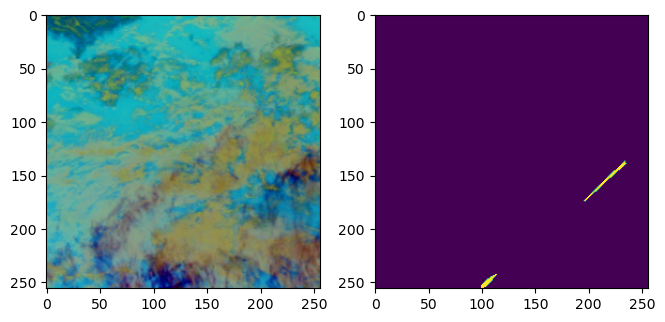

In [5]:
ground_truth = np.load(os.path.join(entry_folder, 'human_pixel_masks.npy'))

plt.figure(figsize=(12, 6))
ax = plt.subplot(1, 3, 1)
ax.imshow(image)

ax = plt.subplot(1, 3, 2)
ax.imshow(ground_truth)

plt.show()

This one is a bit hard to see, so we'll choose another image with more contrails. For simplicity, I'll include a function to do the plotting for us.

In [6]:
def plot_contrails(file_id):
    folder = os.path.join(DATA_PATH, 'validation', file_id)
    # Remember to take the 5th time step, as that's the one the ground truth pertains to.
    band15 = np.load(os.path.join(folder, 'band_15.npy'))[:, :, 5]
    band14 = np.load(os.path.join(folder, 'band_14.npy'))[:, :, 5]
    band11 = np.load(os.path.join(folder, 'band_11.npy'))[:, :, 5]
    ground_truth = np.load(os.path.join(folder, 'human_pixel_masks.npy'))
    # Calculate R, G, and B channels
    red = ((band15 - band14 + 4) / (2 + 4)).clip(0, 1)
    green = ((band14 - band11 + 4) / (5 + 4)).clip(0, 1)
    blue = ((band11 - 243) / (303 - 243)).clip(0, 1)
    # Concatenate them to create a false color image
    image = np.stack((red, green, blue), axis=2)

    plt.figure(figsize=(12, 6))
    ax = plt.subplot(1, 3, 1)
    ax.imshow(image)

    ax = plt.subplot(1, 3, 2)
    ax.imshow(ground_truth)

    plt.show()

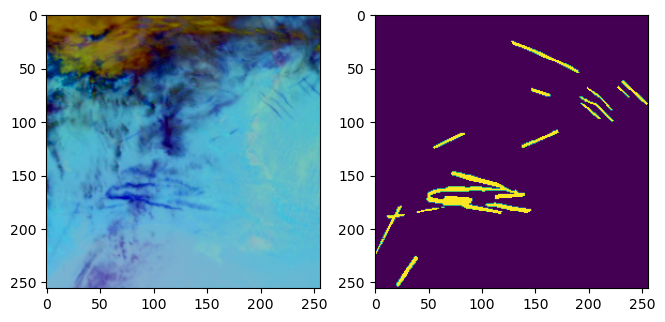

In [7]:
plot_contrails('4617259572479165215')

Hopefully you can see the dark blue wisps in the left image, that correspond with the yellow marks in the right. These are contrails, and these are the pixels that we eventually have to predict.

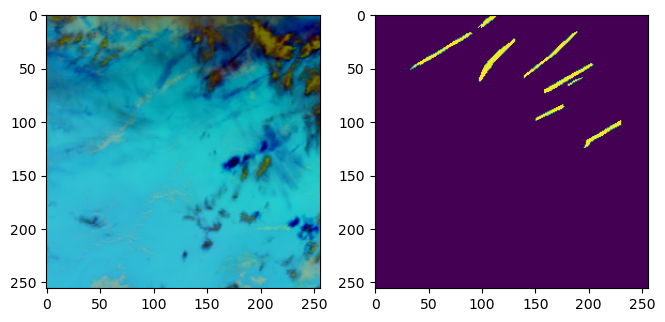

In [8]:
plot_contrails('657695054953474414')

## Examining large collections of images
Next, we'll look the larger collection of images to see if there is something we can conclude or analyze further.

In [9]:
from sklearn.model_selection import train_test_split
import os

In [10]:
all_files = [os.path.basename(subdir) for subdir, _, _ in os.walk(os.path.join(DATA_PATH, 'validation'))][1:]
all_files[:5]

['1000834164244036115',
 '1002653297254493116',
 '1002777035567823518',
 '1010397530434035516',
 '1012978360687713914']

In [11]:
np.random.seed(1729)

In [13]:
train_files, val_files = train_test_split(all_files, test_size=0.2)

7748036876785316817


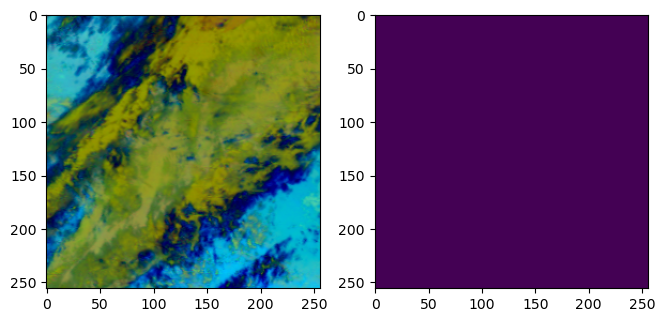

9068219659217929514


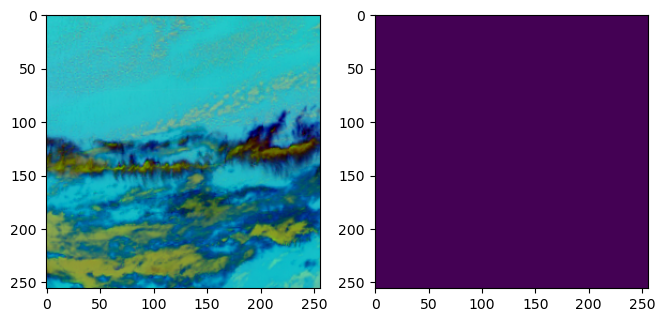

8119825197224433510


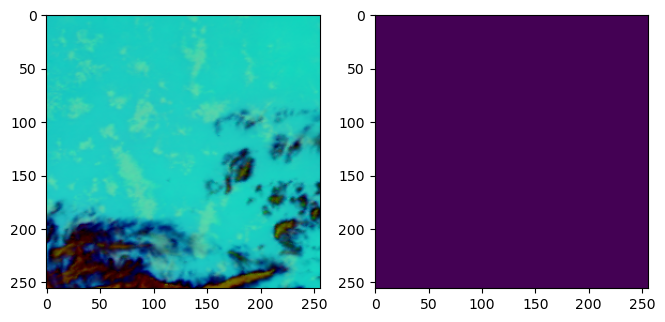

6547968163666055013


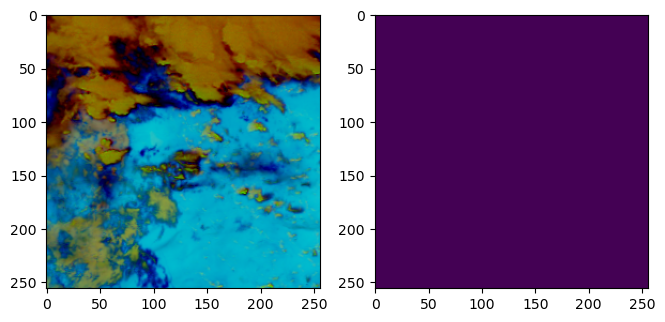

3507283938974085710


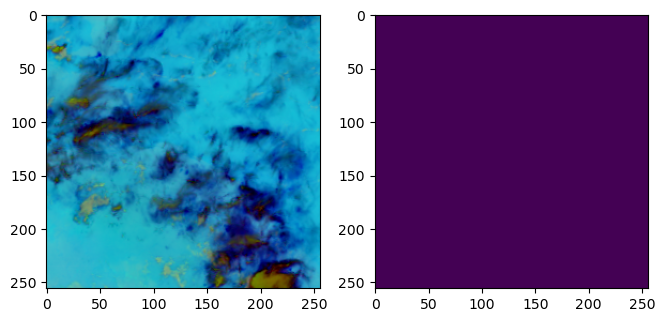

9000307066571621514


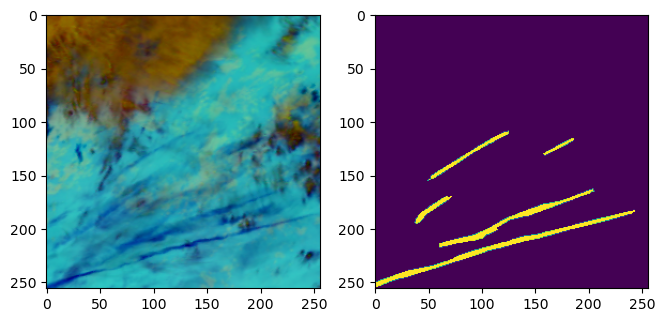

8901565707298847012


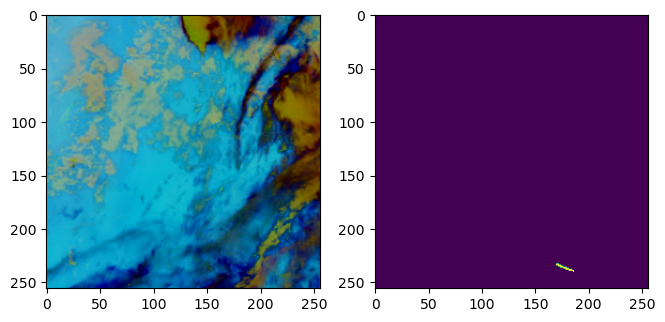

1857226356190155216


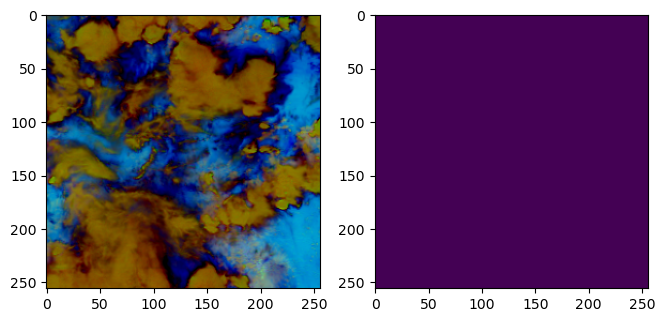

2096276202490315111


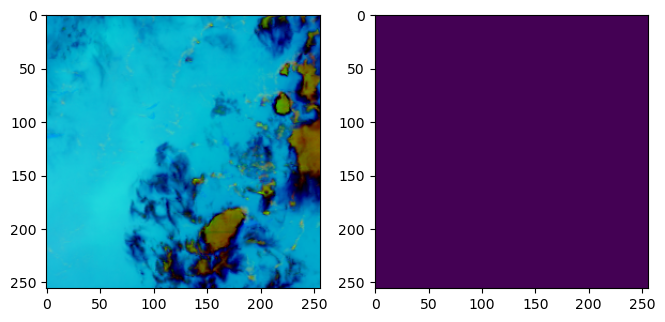

4533054031735045416


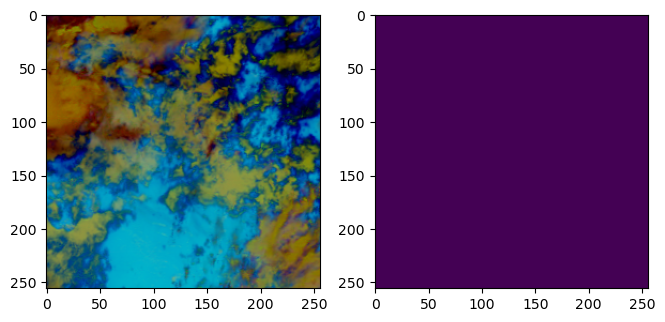

In [15]:
for iid in np.random.choice(val_files, size=10, replace=False):
    print(iid)
    plot_contrails(iid)

In the above sample, you can see that a lot of images barely have any contrails in them. In fact, there are a good number that don't have *any*. Let's count how many images don't contain any contrails. A reminder that we are dealing with the validation data, so the total number of training images will be estimate.

In [11]:
count = 0
for file_id in validation_files:
    ground_truth = np.load(os.path.join(DATA_PATH, file_id, 'human_pixel_masks.npy'))
    if np.any(ground_truth):
        count += 1
print(f'There are {count} images out of {len(validation_files)} ({count / len(validation_files) * 100:2.2f}%) that contain contrails.')

There are 552 images out of 1856 (29.74%) that contain contrails.


So approximately 30% of images **do** contain contrails at all. This percentage is low enough that it might be fruitful to create a model that simply determines whether there are *any* contrails, and only if that model returns True, do we even attempt to predict the exact pixels with contrails.

Another thing we can look at is how many pixels are actually contrails as a percentage of all the pixels. We take a look at for all images, and for all images that contain contrails. This will inform us about what sorts of raw accuracies we should expect.

In [14]:
contrail_pixels = 0
for file_id in validation_files:
    ground_truth = np.load(os.path.join(DATA_PATH, file_id, 'human_pixel_masks.npy'))
    contrail_pixels += np.sum(ground_truth)
# The image sizes are 256 x 256 for a total of 65536 pixels per image.
# The count variable contains the number of images with contrails.
print(f'There are a total of {contrail_pixels} contrail pixels. This comprises {contrail_pixels / (256 * 256 * len(validation_files)) * 100:2.4f}% of ALL images, and {contrail_pixels / (256 * 256 * count) * 100:2.4f}% of images with contrails in them.')

There are a total of 220446 contrail pixels. This comprises 0.1812% of ALL images, and 0.6094% of images with contrails in them.


As expected, the percentage is very low. Even for a model that is only training on images with contrails in them, a raw accuracy could theoretically be as high as 99.39%! This is the main reason why the competition uses the Dice coefficient as the metric, which only looks at the predicted contrail pixels and the 220446 contrail pixels.

## Other Literature Review
The [original paper](https://arxiv.org/pdf/2304.02122.pdf) where the data comes from lists several benchmarking models that were used as performance indicators. I can also do something similar, just so that we have some build-up of performance, and "scores" to beat as we continuously improve our model. One conclusion is that the model does better when presented with **past** timesteps as opposed to future timesteps. Additionally, we have Kulik et al.'s paper, which attempts to implement deep learning on contrail images as well, and presents the color scheme we showed above. On the technical side, we have [a paper](https://www.sciencedirect.com/science/article/abs/pii/S1077314221000655) on the intersection between images and time-series. It lists a novel architecture, called Deep-STaR, to incorporate the time dependency in a list of time-series images, as opposed to simply providing as channels to the image.

### Workflow
We can try many things in order, from a simple convolutional neural network, to using existing image architectures, training on the single ground-truth image, as well as all the time-series images. We can also test training as single predictive model, or a system that contains binary model that first determines whether there are any contrails at all, and an additional contrail model. Finally, we can include the Deep-STaR model as well to see if it improves performance.

## Summary
The following steps will be taken to slowly build-up our model and show progress.

1. One model on **all images** that follows the UNet architecture, with an encoder and decoder. This one will be built from scratch. The input will be the false color image at the exact time step (3 channels for RGB).
2. A UNet with a backbone of one pretrained image model.
3. Repeat above process with binary classification model that predicts whether there are any contrails at all. Input will be the same.
4. Try the same models again, but this time input the timesteps as **channels**. One each for just the past time steps, one for just the future steps, and one for all time steps. If the binary classification improved performance last time, then carry that over.
5. Implement the specialized GAN that Kulik talks about, where the generator predicts contrails, and the discriminator predicts between ground truth labels and predictions, in order to steer the generator to train under a specialized loss function. This results in cleaner predictions of the contrails.
5. Try out Deep-STaR, along with the GAN, with both false color images, and the raw band values as well.

The experiments will be on Weights and Biases, and obviously skirt over the fact about preprocessing. Additionally, there are many other things we could try as well. Maybe the model could work wonderfully with just false color images being fed through the model.

### Some Notes about Preprocessing
With images, there are many image augmentation techniques we can do, from rotating to reflecting and such. However, because we have multiple images being input, and an image-like output (the mask), any augmentation process will need to be repeated exactly for all images involved for that data piece.